# Data Preparation

In [ ]:
import matplotlib.pyplot as plt


def show(image, title=None):
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

## 1. Load the Image

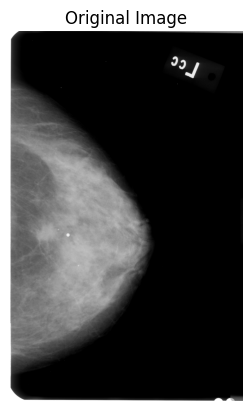

In [3]:
import numpy as np
from PIL import Image

image_path = "data/cbis-ddsm/train/images/P_00001_LEFT_CC_density_3.png"
image_orig = Image.open(image_path)
show(image_orig, "Original Image")

## 2. Contrast Adjustment with CLAHE

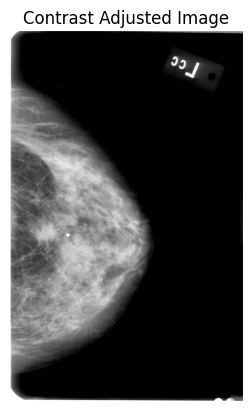

In [4]:
import cv2

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_clahe = clahe.apply(np.array(image_orig, dtype=np.uint8))
image_clahe = Image.fromarray(image_clahe)
show(image_clahe, "Contrast Adjusted Image")

## 3. Data Augmentation

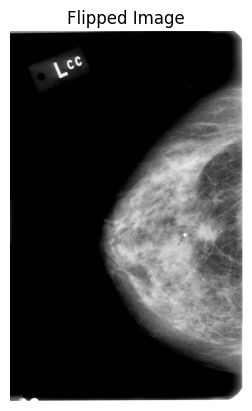

In [5]:
import torchvision.transforms.functional as TF

image_flip = TF.hflip(image_clahe)
show(image_flip, "Flipped Image")

In [6]:
def zoom_image(
    image: Image.Image,
    zoom_factor: float = 1.5,
) -> Image.Image:
    width, height = image.size
    new_width = int(width / zoom_factor)
    new_height = int(height / zoom_factor)

    top = (height - new_height) // 2
    left = (width - new_width) // 2

    image_cropped = TF.crop(image, top, left, new_height, new_width)
    image_resized = TF.resize(image_cropped, (height, width))

    return image_resized

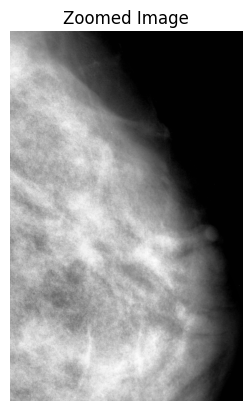

In [7]:
image_zoom = zoom_image(image_clahe, 4)
show(image_zoom, "Zoomed Image")

## 4. Resizing

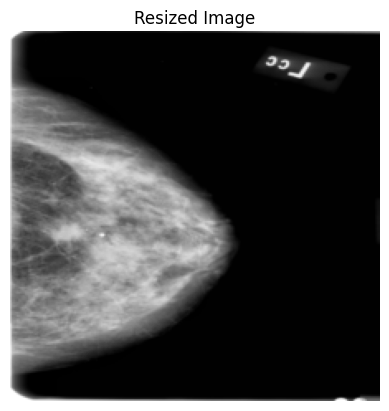

In [8]:
import torchvision.transforms.functional as TF

target_size = (224, 224)
image_resize = TF.resize(image_clahe, target_size)
show(image_resize, "Resized Image")

## 5. Normalizaton/Scaling of Pixel Values

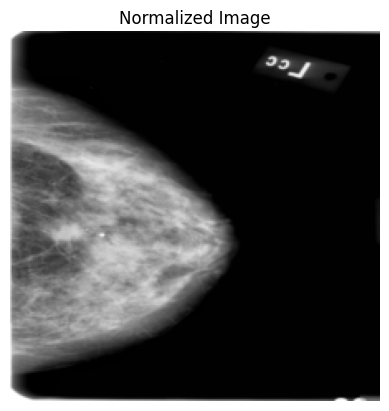

In [9]:
# This won't actually show an image with normalized pixel values
# This is here only for the purpose of demonstraion
image_norm = TF.to_pil_image(TF.to_tensor(image_resize))
show(image_norm, "Normalized Image")

## Example Usage of the Dataset

In [10]:
import matplotlib.pyplot as plt


def show_masks(ax, image, masks):
    ax.imshow(image, cmap="gray")
    for mask in masks:
        ax.imshow(mask, alpha=0.3)

In [11]:
from src.data_module import CbisDdsmDataset

dataset = CbisDdsmDataset("data/cbis-ddsm/train")

0 (3648, 5840) 1
1 (3008, 4608) 6
2 (3432, 5880) 1


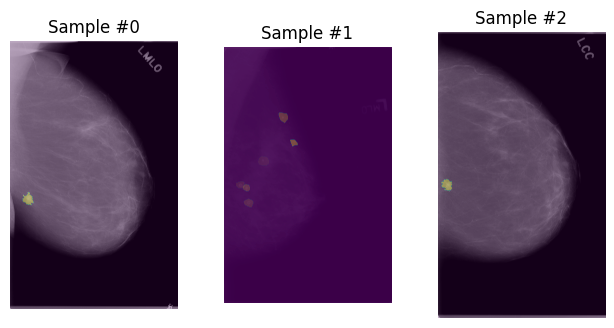

In [12]:
plt.figure()

for i, sample in enumerate(dataset):
    print(i, sample["image"].size, len(sample["masks"]))

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(f"Sample #{i}")
    ax.axis("off")
    show_masks(ax, **sample)

    if i == 2:
        plt.show()
        break

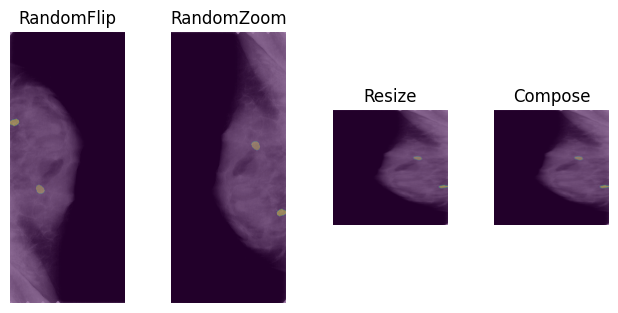

In [ ]:
import torchvision.transforms as transforms

from src.data_module import RandomFlip, RandomZoom, Resize

flip = RandomFlip(0.5, 0.5)
zoom = RandomZoom(2, 0.5)
resize = Resize((224, 224))
composed = transforms.Compose([flip, zoom, resize])

fig = plt.figure()
sample = dataset[42]
for i, tsfrm in enumerate([flip, zoom, resize, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.axis("off")
    show_masks(ax, **transformed_sample)

plt.show()

In [14]:
from src.data_module import ToTensor

transformed_dataset = CbisDdsmDataset(
    "data/cbis-ddsm/train",
    transform=transforms.Compose(
        [
            Resize((224, 224)),
            RandomZoom(2, 0.5),
            RandomFlip(0.5, 0.5),
            ToTensor(),
        ]
    ),
)

for i, sample in enumerate(transformed_dataset):
    print(i, sample["image"].size(), len(sample["masks"]), sample["masks"][0].size())

    if i == 2:
        break

0 torch.Size([1, 224, 224]) 1 torch.Size([1, 224, 224])
1 torch.Size([1, 224, 224]) 6 torch.Size([1, 224, 224])
2 torch.Size([1, 224, 224]) 1 torch.Size([1, 224, 224])
